In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-sales-data/sales_data_sample.csv


                                                                            CUSTOMER SEGMENTATİON
# Before we begin;
  * If you like my work, please upvote this kernel because it will motivated me for more research and work. 
  
# Introduction;
  * Firstly we will explore the dataset and we will make some visualizations.
  * We will create a new dataset which is about rfm analysis. With the dataset we are going to segment the customers with some properties.
  * We will use the Kmeans algorithm and several dimensionality reduction techniques.

In [2]:
data = pd.read_csv('../input/sample-sales-data/sales_data_sample.csv', encoding = 'unicode_escape')
print("data shape is:", data.shape, "*"*50)
data.head(3)

data shape is: (2823, 25) **************************************************


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium


In [3]:
describe = data.describe().T
describe.style.background_gradient(cmap = "Oranges")

,count,mean,std,min,25%,50%,75%,max
ORDERNUMBER,2823.000000,10258.725115,92.085478,10100.000000,10180.000000,10262.000000,10333.500000,10425.000000
QUANTITYORDERED,2823.000000,35.092809,9.741443,6.000000,27.000000,35.000000,43.000000,97.000000
PRICEEACH,2823.000000,83.658544,20.174277,26.880000,68.860000,95.700000,100.000000,100.000000
ORDERLINENUMBER,2823.000000,6.466171,4.225841,1.000000,3.000000,6.000000,9.000000,18.000000
SALES,2823.000000,3553.889072,1841.865106,482.130000,2203.430000,3184.800000,4508.000000,14082.800000
QTR_ID,2823.000000,2.717676,1.203878,1.000000,2.000000,3.000000,4.000000,4.000000
MONTH_ID,2823.000000,7.092455,3.656633,1.000000,4.000000,8.000000,11.000000,12.000000
YEAR_ID,2823.000000,2003.815090,0.699670,2003.000000,2003.000000,2004.000000,2004.000000,2005.000000
MSRP,2823.000000,100.715551,40.187912,33.000000,68.000000,99.000000,124.000000,214.000000


In [4]:
columns  = data.columns
nunique = pd.DataFrame(data[columns].nunique())
nunique.style.background_gradient(cmap="turbo")

,0
ORDERNUMBER,307
QUANTITYORDERED,58
PRICEEACH,1016
ORDERLINENUMBER,18
SALES,2763
ORDERDATE,252
STATUS,6
QTR_ID,4
MONTH_ID,12
YEAR_ID,3


# FOR RFM ANALYSIS
1. "SALES" column is for "monetory"
2. "ORDERDATE" column is for "recency"
3. "QUANTITYORDERED" column is for "frequency"

In [5]:
print("Total Missing Values Numbers of columns;")
isnull = pd.DataFrame(data.isnull().sum())
isnull.style.background_gradient(cmap="ocean")

Total Missing Values Numbers of columns;


,0
ORDERNUMBER,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
ORDERDATE,0
STATUS,0
QTR_ID,0
MONTH_ID,0
YEAR_ID,0


In [6]:
fig = px.pie(data, names='COUNTRY', title='Country Pie Chart')
fig.show()

In [7]:
# I will not take any action for the 3 columns that have empty value. The odd are too high and it's not the main focus of the project.
# However, I need to get rid of the missing values for future PCA technique.

addresline2_missing_value_rates = data["ADDRESSLINE2"].isnull().sum() * 100 / len(data)
state_missing_value_rates = data["STATE"].isnull().sum() * 100 / len(data)
terrıtory_missing_value_rates = data["TERRITORY"].isnull().sum() * 100 / len(data)

print("ADDRESSLINE2 missing value rates % : ",round(addresline2_missing_value_rates,3))
print("STATE missing value rates % : ",round(state_missing_value_rates,3))
print("TERRITORY missing value rates % : ",round(terrıtory_missing_value_rates,3))

data = data.drop(["ADDRESSLINE2","STATE","TERRITORY"], axis=1)


ADDRESSLINE2 missing value rates % :  89.302
STATE missing value rates % :  52.639
TERRITORY missing value rates % :  38.045


# Here we can see that a few of our columns have missing data. However, these columns are not important for RFM analysis or clustering. So let's skip these steps and get back to our topic.

# Let's organize the date-related data to ensure the concept of recency, that is timing and innovation.

In [8]:
data["ORDERDATE"] = pd.to_datetime(data["ORDERDATE"]) 

print("Data içindeki son tarih:", data["ORDERDATE"].max())
print("Data içindeki ilk tarih:", data["ORDERDATE"].min())
#son tarihi referans alarak ilgili işlemlerimi yapıyorum
import datetime as dt
Now = dt.datetime(2005,5,31)

Data içindeki son tarih: 2005-05-31 00:00:00
Data içindeki ilk tarih: 2003-01-06 00:00:00


In [9]:
data["recency_day"] = (Now - data["ORDERDATE"]).astype(str)
data[["recency_day", "B"]] = data["recency_day"].str.split(" ",expand = True)
data = data.drop(["B", "ORDERDATE"], axis=1)

# I am curious about the change of the data variable on a daily basis and let's draw a plot for this.

<function matplotlib.pyplot.show(close=None, block=None)>

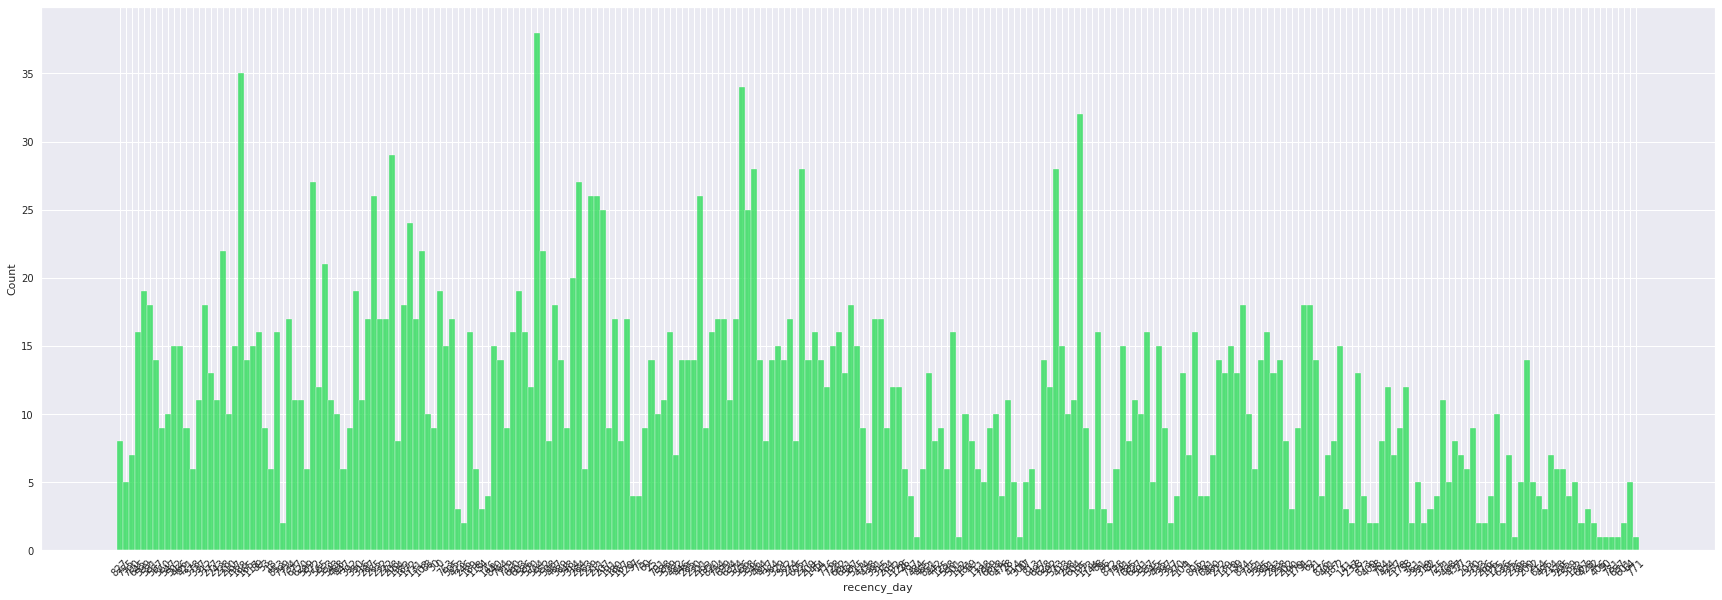

In [10]:
plt.figure(figsize=(30,10))
sns.set_style("darkgrid")
sns.histplot(data['recency_day'], bins=50,
            discrete = True,
            color = "#21DA4F")
plt.xticks(rotation=45)
plt.show

In [11]:
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,...,CUSTOMERNAME,PHONE,ADDRESSLINE1,CITY,POSTALCODE,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,recency_day
0,10107,30,95.70,2,2871.00,Shipped,1,2,2003,Motorcycles,...,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,10022,USA,Yu,Kwai,Small,827
1,10121,34,81.35,5,2765.90,Shipped,2,5,2003,Motorcycles,...,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,51100,France,Henriot,Paul,Small,755
2,10134,41,94.74,2,3884.34,Shipped,3,7,2003,Motorcycles,...,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Medium,700
3,10145,45,83.26,6,3746.70,Shipped,3,8,2003,Motorcycles,...,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Pasadena,90003,USA,Young,Julie,Medium,645
4,10159,49,100.00,14,5205.27,Shipped,4,10,2003,Motorcycles,...,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,San Francisco,NaN,USA,Brown,Julie,Medium,599


# Let's do the necessary cleaning and checks before doing price analysis.
These controls;

* 1-) is there a negative price value?
* 2-) if there are nan values, they must be filled in correctly.
* 3-) let's look at the distributions of the relevant price values. Normal distribution is a situation we want.
Let's look at normality and statistical tests for price value.



In [12]:
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(data["SALES"]) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(data["SALES"]) ))

excess kurtosis of normal distribution (should be 0): 1.7873782707746377
skewness of normal distribution (should be 0): 1.160458972499323


# The values for asymmetry and kurtosis between -2 and +2 are considered acceptable in order to prove normal univariate distribution (George & Mallery, 2010). 

In [13]:
temp  = pd.DataFrame(data["SALES"]).describe().T
temp.style.background_gradient(cmap="autumn_r")
#Herhangi bir negatif değerimiz yok. Bu kontrol analizimiz için oldukça önemli.

,count,mean,std,min,25%,50%,75%,max
SALES,2823.000000,3553.889072,1841.865106,482.130000,2203.430000,3184.800000,4508.000000,14082.800000


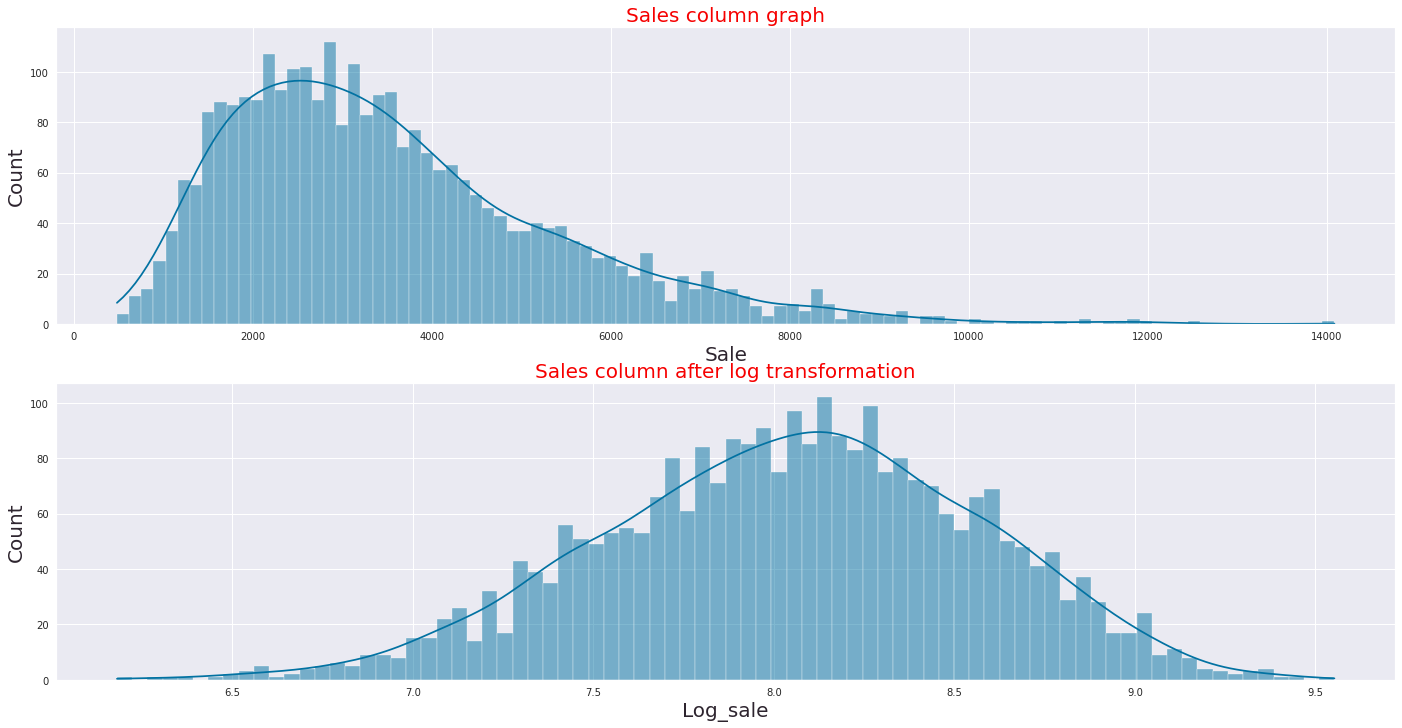

In [14]:
data['price_log'] = np.log(data['SALES']+1) 
#Bunun için daha farklı dönüşüm tipleri de bulunmaktadır.
fig, axarr = plt.subplots(2, 1, figsize=(24, 12))

sns.histplot(data["SALES"], bins=100,kde=True,ax=axarr[0])
axarr[0].set_title("Sales column graph", color="#f60000", size=20)
axarr[0].set_ylabel('Count', fontsize = 20, color="#2d242e")
axarr[0].set_xlabel('Sale', fontsize = 20, color="#2d242e")

sns.histplot(data['price_log'], bins=80, kde=True, ax=axarr[1])
axarr[1].set_title("Sales column after log transformation", color="#f60000", size=20)
axarr[1].set_ylabel('Count', fontsize = 20, color="#2d242e")
axarr[1].set_xlabel('Log_sale', fontsize = 20, color="#2d242e")
fig.show()

In [15]:
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(data["price_log"]) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(data["price_log"]) ))

excess kurtosis of normal distribution (should be 0): -0.16961262504353725
skewness of normal distribution (should be 0): -0.20150542936667845


# It's more normal !

# The next step is to group the total expenditures per customer by frequency and recency.
* A customer can have multiple purchases or date variables. we can then average these values and reach our final goal.

In [16]:
data_rfm = data.groupby(["CUSTOMERNAME"]).agg({
    "ORDERNUMBER" :"count",
    "SALES":  "sum",
    "recency_day":"min"})  # burada min değerini seçerek müşterinin en son ne zaman işlem yaptığı bilgisine ulaşıyorum.

data_rfm.rename(columns={'recency_day': 'Recency',
                   'ORDERNUMBER': 'Frequency',
                   'SALES': 'Monetary'}, inplace=True)

In [17]:
data_rfm.iloc[:5].style.background_gradient(cmap="Pastel1", low=0.50, high=1.0)

,Frequency,Monetary,Recency
CUSTOMERNAME,,,
"AV Stores, Co.",51,157807.810000,195
Alpha Cognac,20,70488.440000,570
Amica Models & Co.,26,94117.260000,264
"Anna's Decorations, Ltd",46,153996.130000,131
Atelier graphique,7,24179.960000,187


# Lets make a RFM_score variable 

In [18]:
data_rfm["Recency"] = data_rfm["Recency"] .astype(int)

In [19]:
zamansallık = pd.qcut(data_rfm["Recency"], q = 5, labels = range(1,6)).astype(str)
sıklık = pd.qcut(data_rfm["Frequency"], q = 5,    labels = range(1,6)).astype(str)
parasallık = pd.qcut(data_rfm["Monetary"], q = 5, labels = range(1,6)).astype(str)

data_rfm["R"] = zamansallık
data_rfm["F"] = sıklık
data_rfm["M"] = parasallık
data_rfm["RFM_score"] = data_rfm["R"]+ data_rfm["F"] +data_rfm["M"]
data_rfm.iloc[:5].style.background_gradient(cmap="Pastel1", low=0.50, high=1.0)

,Frequency,Monetary,Recency,R,F,M,RFM_score
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",51,157807.810000,195,3,5,5,355
Alpha Cognac,20,70488.440000,570,5,2,2,522
Amica Models & Co.,26,94117.260000,264,4,3,3,433
"Anna's Decorations, Ltd",46,153996.130000,131,1,5,5,155
Atelier graphique,7,24179.960000,187,2,1,1,211


# puanları genel olarak toplayıp ona göre aksiyon almak bizi yanıltabilir. O yüzden R, F ve m başlıklarını ayrı ayrı değerlendirmemiz gerektiğini düşünüyorum
# RFM score'ları 511 ve 133 olan müşterilerin genel skorları aynıdır yani 7. Ancak bu iki müşteri grubu için aynı kampanyaları yapmak pek de verimli olmayabilir.
# Strateji olarak;
* örnek olarak rfm skorları şu şekilde olan müşteriler için ;
* RFM_score = xx5  => Bu segmentasyondaki müşteriler için en pahalı ürünleri pazarlamaya çalış
* RFM_score = 311 / 411 segmentinde olan müşteriler için agresif indirim kampanyaları düzenlenerek, ilgili müşteriler tekrar şirkete kazandırılabilir.

In [20]:
data_rfm[["Frequency","Monetary", "Recency"]] = data_rfm[["Frequency","Monetary", "Recency"]].astype(float)

In [21]:
R = pd.DataFrame(data_rfm["R"].value_counts())
M = pd.DataFrame(data_rfm["M"].value_counts())
F = pd.DataFrame(data_rfm["F"].value_counts())

In [22]:

fig = make_subplots(rows=1, cols=3, specs=[[{"type": "pie"}, {"type": "pie"},{"type": "pie"}]])


fig.add_trace(go.Pie(
     values=[19,18,19,17,19],
     labels=["1","2","3","4","5"],
     domain=dict(x=[0, 0.5]),
     name="GHG Emissions",
     title="Müşteri segmentasyonundaki R(recency) dağılımı"), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=[19,18,18,18,19],
     labels=["1","2","3","4","5"],
     domain=dict(x=[0, 0.5]),
     name="GHG Emissions",
     title="Müşteri segmentasyonundaki M(mondetory) dağılımı"), 
     row=1, col=2)

fig.add_trace(go.Pie(
     values=[20,18,19,17,18],
     labels=["1","2","3","4","5"],
     domain=dict(x=[0, 0.5]),
     name="GHG Emissions",
     title="Müşteri segmentasyonundaki F(frequency) dağılımı"), 
     row=1, col=3)

fig.show()

# Müşterilerin 3 kriter içinde yakın dağılım gösterdiğini söyleyebiliriz.

# Kmeans algoritmasının çok daha verimli çalıştırmak için bazı düzenlemeler yapmalıyız. Bunun için;

1. İlgili değişkenlerin normal dağılıma sahip olması,
2. Değişkenlerin aynı veya yakın ortalamada olması,
3. Değişkenlerin aynı veya yakın varyans değerlerine sahip olması.

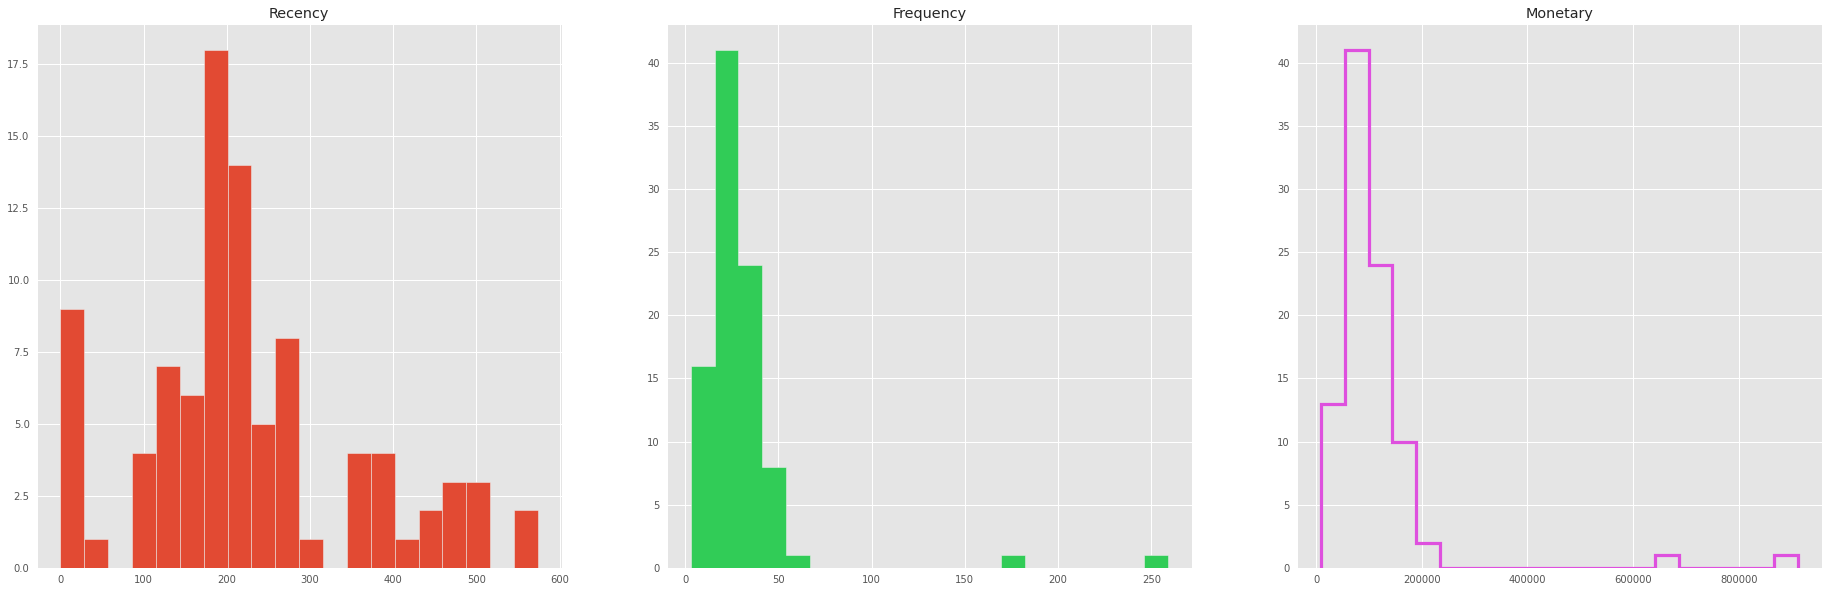

In [23]:
plt.style.use('ggplot')
fig, axarr = plt.subplots(1, 3, figsize=(32, 10))

axarr[0].hist(data_rfm['Recency'], bins=20, histtype= 'bar')
axarr[0].set_title("Recency")

axarr[1].hist(data_rfm['Frequency'], bins=20, histtype= 'stepfilled', color="#31CC57")
axarr[1].set_title("Frequency")

axarr[2].hist(data_rfm['Monetary'], bins=20,histtype= 'step', linewidth=3.2, color="#DE50DE")
axarr[2].set_title("Monetary")
plt.show()


1. Satış fiyatlarını daha önce logaritmik dönüşüm ile normal dağılıma yaklaştırmıştık.
2. Aynı adımları diğer değişkenler için yapalım.

In [24]:
data_rfm["Recency"] = np.log(data_rfm["Recency"]+1)
data_rfm["Frequency"] = np.log(data_rfm["Frequency"]+1)
data_rfm["Monetary"] = np.log(data_rfm["Monetary"]+1)

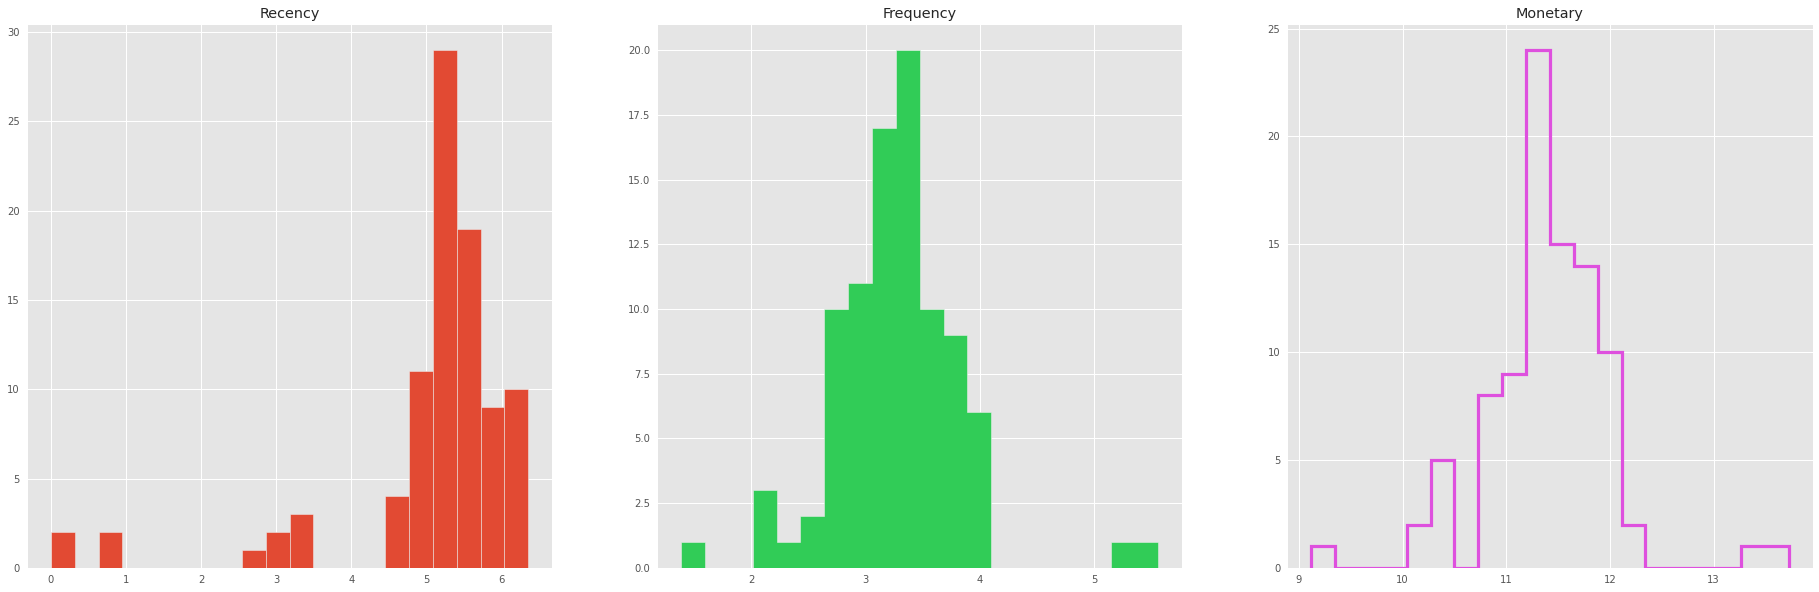

In [25]:
plt.style.use('ggplot')
fig, axarr = plt.subplots(1, 3, figsize=(32, 10))

axarr[0].hist(data_rfm['Recency'], bins=20, histtype= 'bar')
axarr[0].set_title("Recency")

axarr[1].hist(data_rfm['Frequency'], bins=20, histtype= 'stepfilled', color="#31CC57")
axarr[1].set_title("Frequency")

axarr[2].hist(data_rfm["Monetary"], bins=20,histtype= 'step', linewidth=3.2, color="#DE50DE")
axarr[2].set_title("Monetary")
plt.show()


In [26]:
data_rfm.iloc[:5].style.background_gradient(cmap="autumn_r", low=0.50, high=1.0)

,Frequency,Monetary,Recency,R,F,M,RFM_score
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",3.951244,11.969140,5.278115,3,5,5,355
Alpha Cognac,3.044522,11.163218,6.347389,5,2,2,522
Amica Models & Co.,3.295837,11.452307,5.579730,4,3,3,433
"Anna's Decorations, Ltd",3.850148,11.944689,4.882802,1,5,5,155
Atelier graphique,2.079442,10.093321,5.236442,2,1,1,211


# Why do we need scaling?
Machine learning algorithm just sees number  if there is a vast difference in the range say few ranging in thousands and few ranging in the tens, and it makes the underlying assumption that higher ranging numbers have superiority of some sort. So these more significant number starts playing a more decisive role while training the model.

In [27]:
sc = StandardScaler()
scale_data =sc.fit_transform(data_rfm.iloc[:,:3])
scale_data = pd.DataFrame(scale_data, index = data_rfm.index, columns = ["Frequency", "Monetary", "Recency"])

In [28]:
temp  = pd.DataFrame(scale_data).describe().T
temp.style.background_gradient(cmap="autumn_r")

,count,mean,std,min,25%,50%,75%,max
Frequency,92.000000,0.000000,1.005479,-3.413681,-0.428362,0.049556,0.440181,4.157186
Monetary,92.000000,0.000000,1.005479,-3.817852,-0.393303,-0.040491,0.517077,3.916367
Recency,92.000000,0.000000,1.005479,-4.136017,-0.069299,0.209588,0.442908,1.049270


1. Değişken dağılımları normal dağılıma yaklaştırıldı
2. StandardScale ile ise ortalamaları 0 yaparak Kmeans algoritması iiçn uygun çalışma ortamı hazırladık.

# Görselleştirme için hazır bir kütüphane kullandım. Buradaki siyah çizgi en uygun number_of_cluster' a denk gelmektedir. 
* Bu nokta aynı zamanda grafikteki en yüksek açıya sahip noktadır. (Dirsek Kuralı)

Elbow Method to determine the number of clusters to be formed:


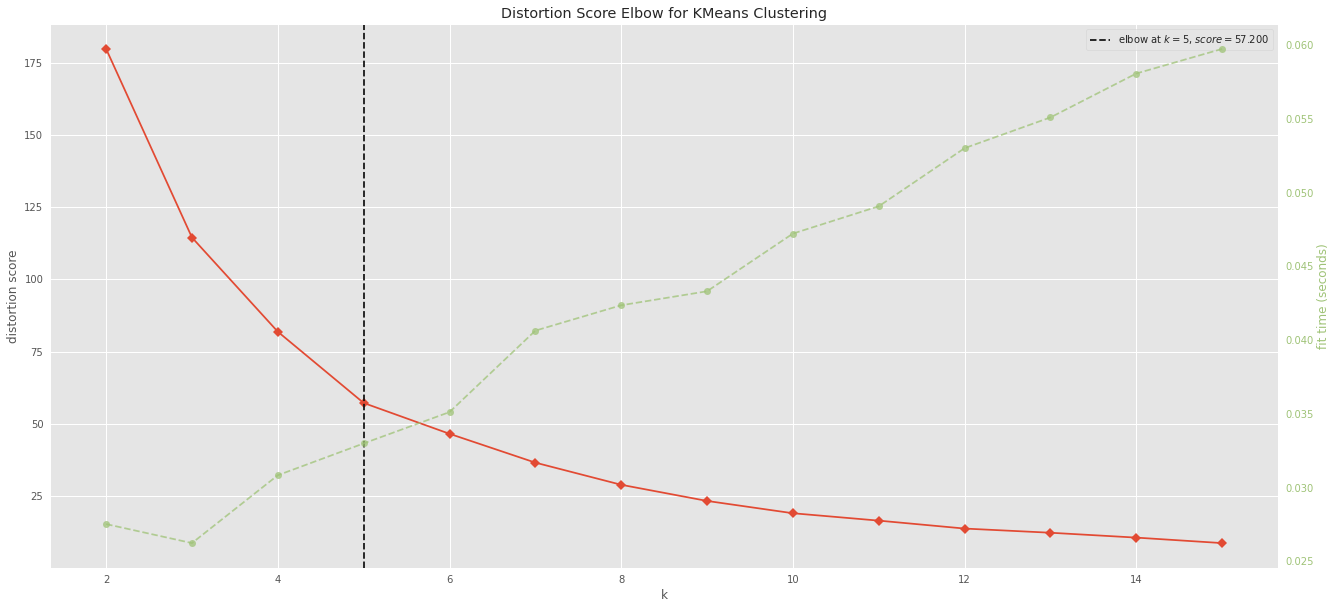

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=15)
plt.figure(figsize=(22,10))
Elbow_M.fit(scale_data)
Elbow_M.show()

In [30]:
# En uygun sınıf sayısına göre kümelememizi yapalım

kmeans = KMeans(n_clusters = 5, random_state = 1)
kmeans.fit(scale_data)
cluster_labels = kmeans.labels_
data_rfm = data_rfm.assign(Cluster=cluster_labels)
data_rfm.head()

,Frequency,Monetary,Recency,R,F,M,RFM_score,Cluster
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",3.951244,11.969140,5.278115,3,5,5,355,0
Alpha Cognac,3.044522,11.163218,6.347389,5,2,2,522,4
Amica Models & Co.,3.295837,11.452307,5.579730,4,3,3,433,4
"Anna's Decorations, Ltd",3.850148,11.944689,4.882802,1,5,5,155,0
Atelier graphique,2.079442,10.093321,5.236442,2,1,1,211,1


In [31]:
data_rfm["Recency"] = np.exp(data_rfm["Recency"])
data_rfm["Frequency"] = np.exp(data_rfm["Frequency"])
data_rfm["Monetary"] =np.exp(data_rfm["Monetary"])

In [32]:
data_rfm[["Frequency","Monetary", "Recency"]] = data_rfm[["Frequency","Monetary", "Recency"]].astype(float)
grouped = data_rfm.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': ['mean','std'],
    'Frequency': ['mean','std'],
    'Monetary': ['mean', 'count']
  }).round(1)

Recency        Frequency        Monetary      
           mean    std      mean   std      mean count
Cluster                                               
0         196.9   94.0      38.8   7.7  135498.7    30
1         343.5  164.3      12.0   3.6   36909.3    13
2          52.5   72.8     220.5  55.9  783577.1     2
3           5.0    6.7      38.2  12.2  131759.5     4
4         241.7  114.7      23.3   3.8   78924.4    43

In [33]:
data_dim = data.merge(data_rfm[['Cluster']], on="CUSTOMERNAME", how="left")

# We will make it numeric for dimension reduction.

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_data = ["PRODUCTCODE","CUSTOMERNAME","PHONE","ADDRESSLINE1","CITY",
              "POSTALCODE","CONTACTLASTNAME","COUNTRY","CONTACTLASTNAME",
              "CONTACTFIRSTNAME","DEALSIZE","recency_day","STATUS","PRODUCTLINE"]
for i in label_data:
    data[i] =  data[i].astype(str)
    data[i] = le.fit_transform(data[i].values)
    
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,...,PHONE,ADDRESSLINE1,CITY,POSTALCODE,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,recency_day,price_log
0,10107,30,95.70,2,2871.00,5,1,2,2003,1,...,48,57,42,0,18,74,36,2,236,7.962764
1,10121,34,81.35,5,2765.90,5,2,5,2003,1,...,54,40,56,27,6,21,54,2,220,7.925483
2,10134,41,94.74,2,3884.34,5,3,7,2003,1,...,16,21,52,41,6,9,11,1,209,8.264966
3,10145,45,83.26,6,3746.70,5,3,8,2003,1,...,76,54,53,49,18,73,31,1,198,8.228898
4,10159,49,100.00,14,5205.27,5,4,10,2003,1,...,77,51,59,73,18,75,31,1,181,8.557619


In [35]:
#PCA 
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
X_pca = pipe.fit_transform(data)

#t-sne
tsne = TSNE()
pipe = Pipeline([("scaler", StandardScaler()), ('tsne', tsne)])
X_tsne = pipe.fit_transform(data)

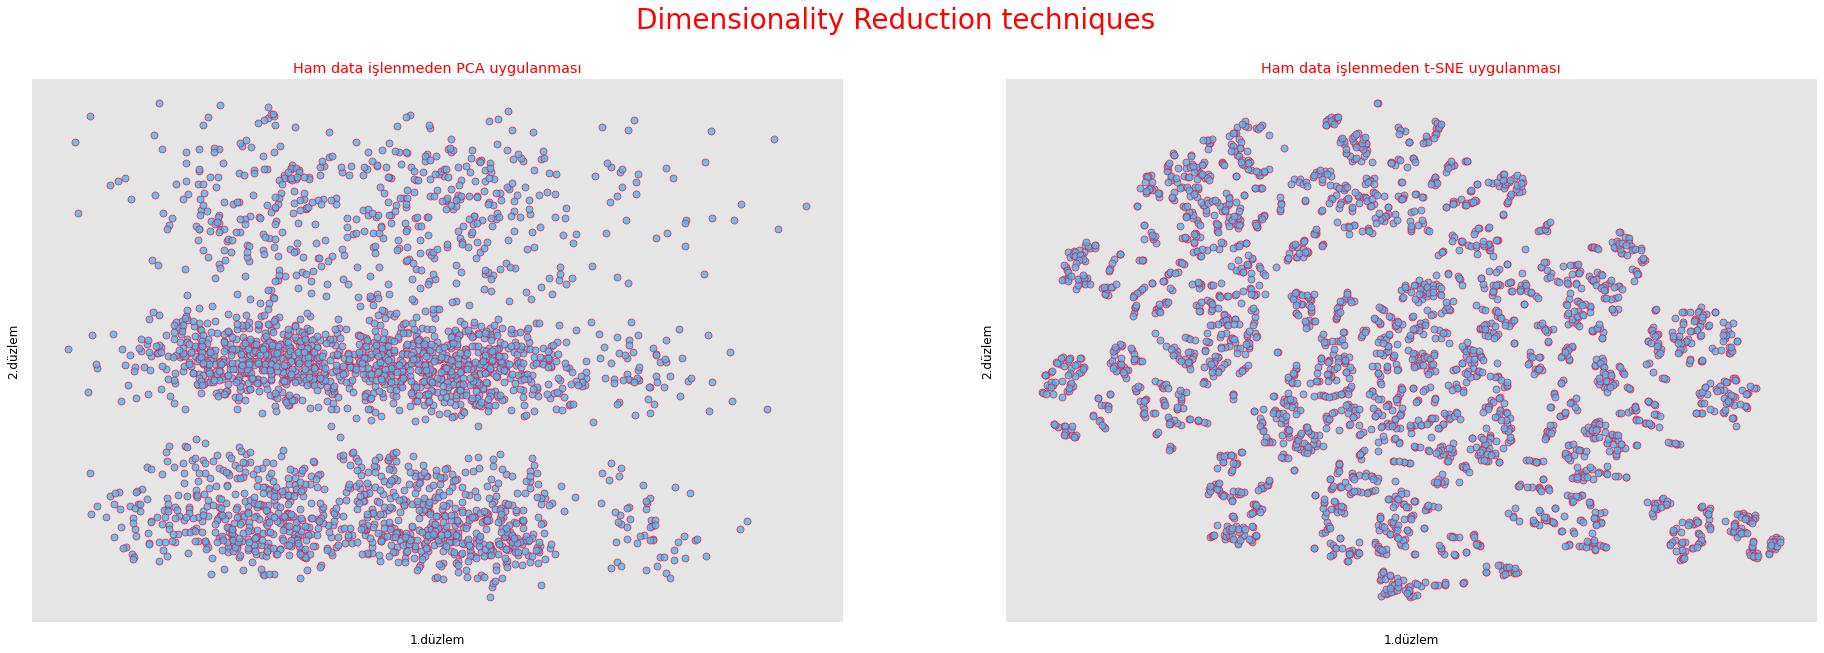

In [36]:
plt.style.use('ggplot')
fig, axarr = plt.subplots(1, 2, figsize=(32, 10))

fig.suptitle("Dimensionality Reduction techniques", color ="red", size = 28)
axarr[0].scatter(X_pca[:,0], X_pca[:,1],alpha=0.8,edgecolors="#F50D2F" ,linewidths=0.8, c="#49BAF1")
axarr[0].set_title("Ham data işlenmeden PCA uygulanması" ,color="red")
axarr[0].set_ylabel("2.düzlem", color ="black")
axarr[0].set_xlabel("1.düzlem", color ="black")
axarr[0].set_yticklabels([])
axarr[0].set_xticklabels([])
axarr[0].grid(False)

axarr[1].scatter(X_tsne[:,0], X_tsne[:,1],alpha=0.8,edgecolors="#F50D2F" ,linewidths=0.8, c="#49BAF1")
axarr[1].set_title("Ham data işlenmeden t-SNE uygulanması" ,color="red")
axarr[1].set_ylabel("2.düzlem", color ="black")
axarr[1].set_xlabel("1.düzlem", color ="black")
axarr[1].set_yticklabels([])
axarr[1].set_xticklabels([])
axarr[1].grid(False)
fig.show()


# son olarak ham data ile cluster kolonunu birleştirerek bir görselleştirme yapalım.

In [37]:

label_data = ["PRODUCTCODE","CUSTOMERNAME","PHONE","ADDRESSLINE1","CITY",
              "POSTALCODE","CONTACTLASTNAME","COUNTRY","CONTACTLASTNAME",
              "CONTACTFIRSTNAME","DEALSIZE","recency_day","STATUS","PRODUCTLINE"]
for i in label_data:
    data_dim[i] =  data_dim[i].astype(str)
    data_dim[i] = le.fit_transform(data[i].values)
    
y = data_dim["Cluster"]

#PCA 
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
X_pca = pipe.fit_transform(data_dim.iloc[:,:23])

pipe = Pipeline([("scaler", StandardScaler()), ('tsne', tsne)])
X_tsne = pipe.fit_transform(data_dim.iloc[:,:23])

print(X_tsne.shape)

(2823, 2)


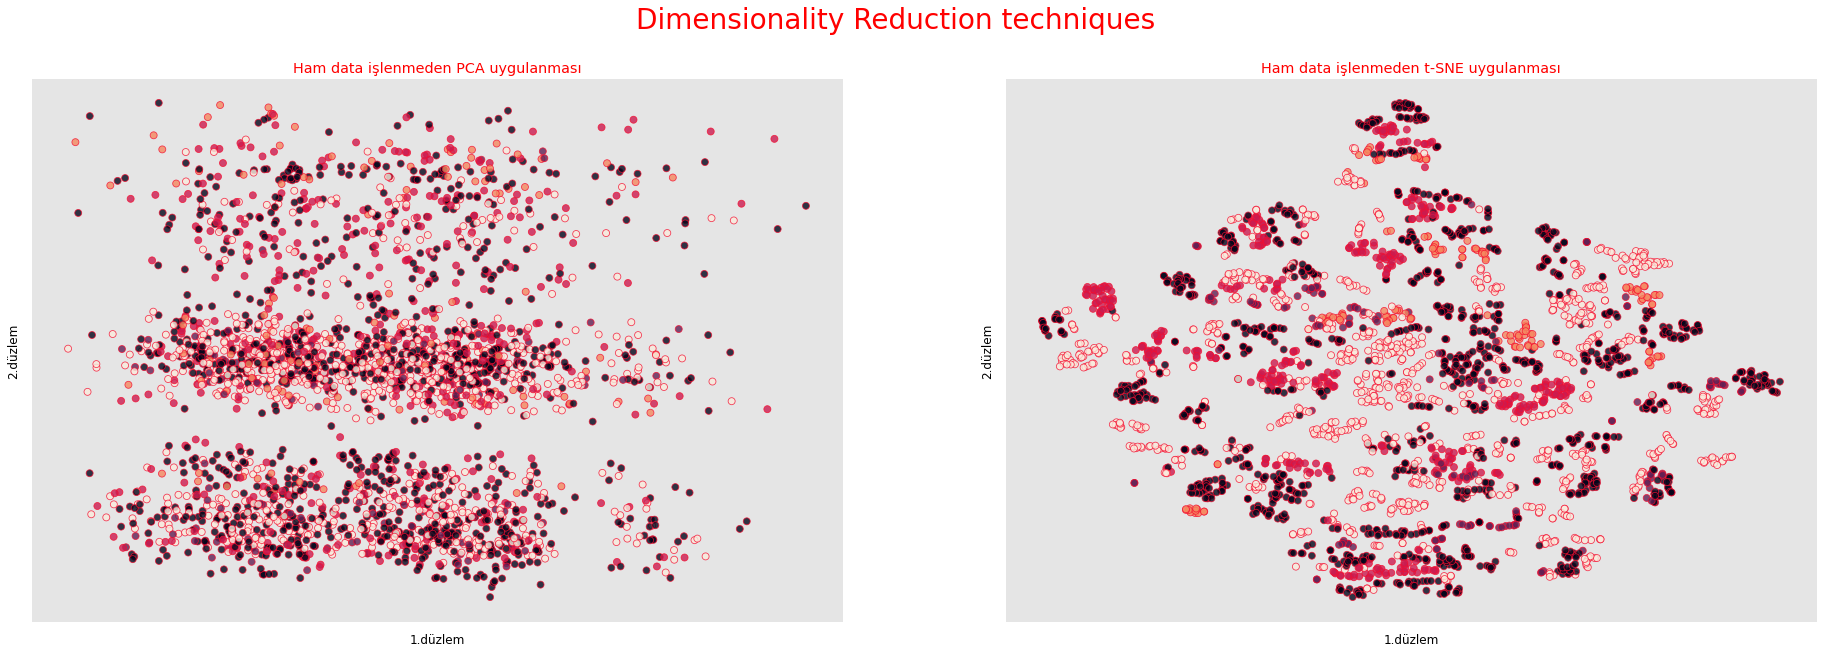

In [38]:
plt.style.use('ggplot')
fig, axarr = plt.subplots(1, 2, figsize=(32, 10))

fig.suptitle("Dimensionality Reduction techniques", color ="red", size = 28)
axarr[0].scatter(X_pca[:,0], X_pca[:,1],alpha=0.8,edgecolors="#F50D2F" ,linewidths=0.8, c=y)
axarr[0].set_title("Ham data işlenmeden PCA uygulanması" ,color="red")
axarr[0].set_ylabel("2.düzlem", color ="black")
axarr[0].set_xlabel("1.düzlem", color ="black")
axarr[0].set_yticklabels([])
axarr[0].set_xticklabels([])
axarr[0].grid(False)

axarr[1].scatter(X_tsne[:,0], X_tsne[:,1],alpha=0.8,edgecolors="#F50D2F" ,linewidths=0.8, c=y)
axarr[1].set_title("Ham data işlenmeden t-SNE uygulanması" ,color="red")
axarr[1].set_ylabel("2.düzlem", color ="black")
axarr[1].set_xlabel("1.düzlem", color ="black")
axarr[1].set_yticklabels([])
axarr[1].set_xticklabels([])
axarr[1].grid(False)
fig.show()

# Sonuç;
1. Rfm analizi sonucu müşteri gruplarının birbirinden farklı olduğunu ve oluşan kümelere göre aksiyon almamız gerektiğini gördük.
2. oluşturduğumuz sıklık, yenilik ve parasallık kavramları ile bu ayrımı yaparak ilgili dataseti(rfm_data) oluşturduk.
3. Dirsek kuralını kullanarak en uygun küme sayısı seçildi.
4. Datanın önce ve sonrası PCA ve TSNE uygulanarak görselleştirildi. 2. kısımda cluster değişkenine göre renklendirerek anlamlı sonuç arandı, ancak bulunamadı.

# References:
* https://www.kaggle.com/alekhyabotta/customer-segmentation
* https://www.kaggle.com/yugagrawal95/k-means-clustering-using-seaborn-visualization
* https://medium.com/@krglnahmetcan/rfm-analizi-ile-m%C3%BC%C5%9Fteri-segmentasyonu-b3c7233b4243
* https://towardsdatascience.com/feature-extraction-using-principal-component-analysis-a-simplified-visual-demo-e5592ced100a
* https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
* https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35#:~:text=Feature%20scaling%20is%20essential%20for,that%20calculate%20distances%20between%20data.&text=Since%20the%20range%20of%20values,not%20work%20correctly%20without%20normalization.
* AND OF COURSE https://stackoverflow.com/